<a href="https://colab.research.google.com/github/yukliio/Autoencoder-Driven-Model-Based-Transfer/blob/main/nbs/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is an autoencoder?

In [14]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt



In [11]:
# load the MNIST dataset

mnist_train = torchvision.datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [29]:
print("Number of training samples:", len(mnist_train))

loader = DataLoader(mnist_train, batch_size=len(mnist_train))
images, ground_truth = next(iter(loader))

Number of training samples: 60000


In [33]:
images = images.squeeze()  # removes dimensions of size (1)
print(images.shape) [6000, 28, 28]
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [35]:
print(torch.min(images[0]))
print(torch.max(images[0]))

images_int = (images * 255).byte()  # convert to 0-255
print(images_int.min(), images_int.max())  # 0 255

tensor(0.)
tensor(1.)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


tensor(7)


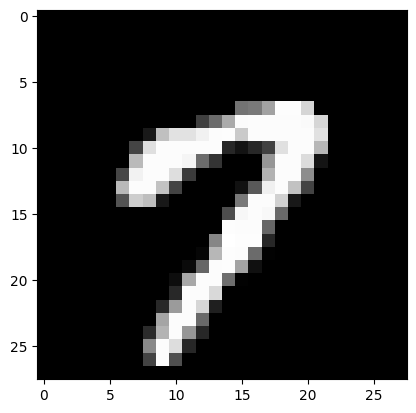

In [36]:
image_index = 15

print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [37]:
import torch
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_train])  # [60000, 1, 28, 28]

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_train])  # [60000]

# save to file
torch.save((all_images, all_labels), 'mnist_train.pt')
print("File saved as mnist_train.pt")

File saved as mnist_train.pt


In [39]:

mnist_test = datasets.MNIST(
    root='./',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)


# stack all images into one tensor
all_images = torch.stack([img for img, label in mnist_test])

# stack all labels into one tensor
all_labels = torch.tensor([label for img, label in mnist_test])

# save to file
torch.save((all_images, all_labels), 'mnist_test.pt')
print("File saved as mnist_test.pt")

File saved as mnist_test.pt


In [ ]:
# map style pytorch dataset

class MNISTDataset(Dataset):
  # need to implement getitem and len methods. creates a map dataste and can query the dataset via index
  def __init__(self, path):
    # loads data into memory
    self.images, self.ground_truth = torch.load(path)

  def __getitem__(self, idx):
    # returns the image with index idx
    x = self.images[idx].float()
    x = torch.flatten(x)
    y = self.ground_truth[idx]

    return x, y

  def __len__(self):
  # returns the length of the dataset
    return len(self.ground_truth)



In [ ]:
# make the dataset
train_dataset = MNISTDataset("mnist_train.pt")

loader = DataLoader(dataset, batch_size=64, shuffle=True)
